In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import sys
sys.path.append("/home/mylab-pharma/Code/tuele/pan_HDAC/mylab_panHDAC-master/src/common")
from pharmacy_common import PharmacyCommon

#class to encode smiles
common = PharmacyCommon()

Import and organize the data

In [2]:
train_dataset = pd.read_excel('../../data/train_test_data/NoCL/20240321_pan_HDAC_train_test_data.xlsx',sheet_name='train_dataset')
validation_dataset = pd.read_excel("../../data/train_test_data/NoCL/20240321_pan_HDAC_train_test_data.xlsx", sheet_name='validation_dataset')
test_dataset = pd.read_excel("../../data/train_test_data/NoCL/20240321_pan_HDAC_train_test_data.xlsx", sheet_name='test_dataset')
print(len(train_dataset),len(validation_dataset), len(test_dataset))

1528 328 327


In [3]:
train_dataset.head(10)

,Code,SMILES,Bioactivity
0,415897,CC(Nc1ccc(CN(CCC=C2CCC(NO)=O)C2=O)cc1)=O,inactive
1,1589183,COc(cc(/C=C/C(Nc(cccc1)c1N)=O)cc1)c1OCC(Nc(cc1...,inactive
2,1161066,CC[C@H](C)[C@@H](C(N(Cc1c(C2)ccc(OCC(NO)=O)c1)...,active
3,2100074,CC(c1ccccc1)Nc1ncnc2c1cc(-c1ccc(CN3CCN(CCOCCCC...,inactive
4,386804,CC(C)SC(SCC(c1ccc(C)cc1)=O)=S,inactive
5,467667,CCOC(SCC(c(cc1)ccc1NC(C)=O)=O)=S,inactive
6,390739,ONC(/C=C/c1cccc(C(c2cc(cccc3)c3[nH]2)=O)c1)=O,active
7,440474,ONC(CCCCCNC(Nc1cc(-c2nc(cccc3)c3[o]2)ccc1)=O)=O,active
8,2460036,CN1C(SCc(cc2)ccc2C(Nc(cccc2)c2N)=O)=Nc(cc(cc2)...,inactive
9,440227,CCC(c1nc(cccc2)c2[n]1CC)c1ccc(/C=C/C(NO)=O)cc1,active


In [4]:
#encoding smiles 
fpt_bits = 1024
X_train = common.gen_ecfp4_fpts(train_dataset['SMILES'],bits = 1024)
X_validation = common.gen_ecfp4_fpts(validation_dataset['SMILES'], bits = 1024)
X_test = common.gen_ecfp4_fpts(test_dataset['SMILES'], bits = 1024)

Progress:   0%|          | 0/1528 [00:00<?, ?it/s][15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50:00] DEPRECATION WARNING: please use MorganGenerator
[15:50

In [5]:
# encoding the label
import sklearn.preprocessing as preprocessing
y_train = np.array(train_dataset['Bioactivity'])
y_validation = np.array(validation_dataset['Bioactivity'])
y_test = np.array(test_dataset['Bioactivity'])

#Original data
print("Original data:")
print(y_train[0:5])
print(y_test[0:5])
print(y_validation[0:5])

#label encoding
label_encoder = preprocessing.LabelEncoder()
y_train  = label_encoder.fit_transform(y_train)
y_validation = label_encoder.fit_transform(y_validation)
y_test = label_encoder.fit_transform(y_test)
#Class encoded
print("Class encoded:")
print(list(label_encoder.classes_))
print(label_encoder.transform(label_encoder.classes_))
print("Encoded data:")
print(y_train[0:5])
print(y_test[0:5])
print(y_validation[0:5])

Original data:
['inactive' 'inactive' 'active' 'inactive' 'inactive']
['active' 'active' 'active' 'inactive' 'active']
['active' 'active' 'inactive' 'inactive' 'inactive']
Class encoded:
['active', 'inactive']
[0 1]
Encoded data:
[1 1 0 1 1]
[0 0 0 1 0]
[0 0 1 1 1]


In [6]:
#converting to tensor 
X_train_df = pd.DataFrame(X_train)
X_validation_df = pd.DataFrame(X_validation)
X_test_df = pd.DataFrame(X_test)

X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
X_validation = torch.tensor(X_validation_df.values, dtype=torch.float32)
X_test = torch.tensor(X_test_df.values, dtype=torch.float32)

y_train_df = pd.DataFrame(y_train)
y_validation_df = pd.DataFrame(y_validation)
y_test_df = pd.DataFrame(y_test)

y_train = torch.tensor(y_train_df.values, dtype=torch.float32)
y_validation = torch.tensor(y_validation_df.values, dtype=torch.float32)
y_test = torch.tensor(y_test_df.values, dtype=torch.float32)

In [7]:
# Create train and test datasets
train_dataset = TensorDataset(X_train, y_train)
validation_dataset= TensorDataset(X_validation, y_validation)
test_dataset = TensorDataset(X_test, y_test)

In [8]:
# Define the data loaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [9]:
len(trainloader)

48

Construct and sanity-check the model

In [10]:
data_train = X_train
data_valdation = X_validation
data_test = X_test

labels_validation = y_validation
labels_test = y_test
labels_train= y_train.float()
print(len(data_train), len(labels_train),len(data_valdation),
    len(labels_validation), len(data_test), len(labels_test))
print(data_train)
print(labels_train)

1528 1528 328 328 327 327
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [1.],
        [1.]])


Finding hyperparameters 

In [11]:
# model
class ann_try(nn.Module):
    def __init__(self, input_dim=1024,layer1=512,layer2=256,drp=.2,output=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,layer1),
            nn.ReLU(),
            nn.Dropout(drp),
            nn.Linear(layer1,layer2),
            nn.ReLU(),
            nn.Dropout(drp),
            nn.Linear(layer2,output),
            nn.Sigmoid(),
        )
    def forward(self,input):
        return self.net(input)

{'target': 84.1463394165039, 'params': {'l2': 0.004176049826978714, 'lr': 0.007206041689487159}}

In [12]:
# trainning
def training(x_train = X_train,y_train=y_train,x_validation = X_validation,
            #  y_validation = y_validation,lr=0.001,l2=0.001,batch_size=64,epochs=100):
            y_validation = y_validation,lr=0.007206041689487159,l2=0.004176049826978714,batch_size=128,epochs=500):
    torch.manual_seed(0)
    losses=[]
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size)
    model = ann_try()
    loss_func = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=l2)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        if epoch==0 or  epoch % 2 == 0:
            print(loss)
        losses.append(loss)
    losses_tensor = torch.tensor(losses)
    plt.title("Loss in training")
    plt.xlabel('Numepoch')
    plt.ylabel('Loss_value')
    plt.plot(losses_tensor.detach())
    
    model.eval()
    y_pred_train = model(x_train)>.5
    acc_train = 100*torch.mean((y_pred_train == y_train).float())
    y_pred = model(x_validation)>.5
    acc_val = 100*torch.mean((y_pred == y_validation).float())

    # mse = mean_squared_error(model(x_validation).detach().numpy(),y_.detach().numpy())
    print('Accuracy on validation set:' ,acc_train)
    print('Accuracy on validation set:' ,acc_val)

    return acc_train, acc_val #to specify what to maximize in this function

tensor(0.5322, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4095, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4307, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2692, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2638, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2484, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2442, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2579, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2876, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2145, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2155, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2402, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1516, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1971, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2224, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2053, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1636, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1337, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1444, grad_fn=<Bina

(tensor(97.9712), tensor(84.7561))

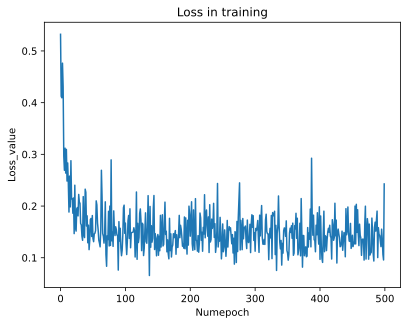

In [13]:
training(X_train,y_train,X_validation,y_validation)

Using Grid Searching

In [13]:
x_train, y_train = np.array(X_train), np.array(y_train)
x_train = x_train.astype(np.float32)
# y_train = y_train.astype(np.float32)
y_train = y_train.astype(np.int64)
# y_train = y_train.flatten()
x_train.type()

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [ ]:
import numpy as np

# Kiểm tra kiểu dữ liệu của mảng y_train
print(type(y_train))

# Kiểm tra kiểu dữ liệu của các phần tử trong mảng y_train
print(y_train.dtype)

# Kiểm tra giá trị tối thiểu và tối đa của mảng y_train
print(np.min(y_train))
print(np.max(y_train))

<class 'numpy.ndarray'>
int64
0
1


In [ ]:
np.unique(y_train)

array([0, 1])

In [ ]:
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
import time

def gs_tune(x_train,y_train):
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = x_train.astype(np.int32)
    # y_train = y_train.astype(np.float32)
    y_train = y_train.astype(np.int64)

    net = NeuralNetClassifier(ann_try(), 
                             optimizer=torch.optim.Adam
                             , max_epochs=30
                             , lr=0.001
                             , verbose=1
                            #  , batch_size=64
                             , optimizer__weight_decay=.001)
    
    params = {
        'lr': np.arange(1e-4,1e-2,.001),
        'optimizer__weight_decay':np.arange(1e-4,1e-2,.001)
    }
    
    y_train=y_train.reshape(-1)
    # y_train = y_train.squeeze()  # Chuyển đổi thành tensor 1D
    # y_train = y_train.flatten()
    x_train = torch.tensor(x_train).float()  # Convert x_train to Float tensor

    gs = GridSearchCV(net, params, refit=True, cv=3)
    gs.fit(x_train, y_train)
    return gs

# Check unique labels in y_train
unique_labels = np.unique(y_train)

# Expected number of classes (adjust based on your data)
num_classes = 2  # Replace with the actual number of classes

# Filter data with valid labels
valid_idx = np.where(np.isin(y_train, np.arange(num_classes)))[0]
x_train_filtered = x_train[valid_idx]
y_train_filtered = y_train[valid_idx]

# Use filtered data for grid search
grid_model = gs_tune(x_train_filtered, y_train_filtered)
# start = time.time()
# grid_model=gs_tune(X_train,y_train)
# end = time.time()
# print('Grid search takes {:.2f} seconds to tune'.format(end - start))

y_pred_train = grid_model(X_train)>.5
acc_train = 100*torch.mean((y_pred_train == y_train).float())
# y_pred_val = grid_model(X_validation)>.5
# acc_val = 100*torch.mean((y_pred_val == y_validation).float())

print('Accuracy on trainset: ', acc_train)
# print("Accuracy on validationset: ", acc_val)

ValueError: 
All the 300 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1319, in fit
    self.partial_fit(X, y, **fit_params)
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1278, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1190, in fit_loop
    self.run_single_epoch(iterator_train, training=True, prefix="train",
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1226, in run_single_epoch
    step = step_fn(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1105, in train_step
    self._step_optimizer(step_fn)
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1060, in _step_optimizer
    optimizer.step(step_fn)
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/optim/optimizer.py", line 385, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/optim/optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/optim/adam.py", line 146, in step
    loss = closure()
           ^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1094, in step_fn
    step = self.train_step_single(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 994, in train_step_single
    loss = self.get_loss(y_pred, yi, X=Xi, training=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/classifier.py", line 150, in get_loss
    return super().get_loss(y_pred, y_true, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1665, in get_loss
    return self.criterion_(y_pred, y_true)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/nn/modules/loss.py", line 216, in forward
    return F.nll_loss(input, target, weight=self.weight, ignore_index=self.ignore_index, reduction=self.reduction)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/nn/functional.py", line 2733, in nll_loss
    return torch._C._nn.nll_loss_nd(input, target, weight, _Reduction.get_enum(reduction), ignore_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
IndexError: Target 1 is out of bounds.


Using Randomized Search

In [ ]:
from skorch import NeuralNetClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import time

def rs_tune(x_train, y_train):
    x_train = np.array(x_train).astype(np.float32)
    y_train = np.array(y_train).astype(np.int64)

    net = NeuralNetClassifier(ann_try,
                              optimizer=torch.optim.Adam,
                              max_epochs=30,
                              verbose=1,
                              batch_size=64
                              )

    params = {
        'lr': uniform(1e-4, 1e-2),
        'optimizer__weight_decay': uniform(1e-4, 1e-2)
    }

    rs = RandomizedSearchCV(net, params, refit=True, n_iter=50, cv=3, scoring='accuracy')
    rs.fit(x_train, y_train)
    return rs

start = time.time()
random_model = rs_tune(x_train, y_train)
end = time.time()
print('Random search takes {:.2f} seconds to tune'.format(end - start))

ValueError: 
All the 150 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1319, in fit
    self.partial_fit(X, y, **fit_params)
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1278, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1190, in fit_loop
    self.run_single_epoch(iterator_train, training=True, prefix="train",
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1226, in run_single_epoch
    step = step_fn(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1105, in train_step
    self._step_optimizer(step_fn)
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1060, in _step_optimizer
    optimizer.step(step_fn)
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/optim/optimizer.py", line 385, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/optim/optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/optim/adam.py", line 146, in step
    loss = closure()
           ^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1094, in step_fn
    step = self.train_step_single(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 994, in train_step_single
    loss = self.get_loss(y_pred, yi, X=Xi, training=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/classifier.py", line 150, in get_loss
    return super().get_loss(y_pred, y_true, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/skorch/net.py", line 1665, in get_loss
    return self.criterion_(y_pred, y_true)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/nn/modules/loss.py", line 216, in forward
    return F.nll_loss(input, target, weight=self.weight, ignore_index=self.ignore_index, reduction=self.reduction)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/torch/nn/functional.py", line 2733, in nll_loss
    return torch._C._nn.nll_loss_nd(input, target, weight, _Reduction.get_enum(reduction), ignore_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
IndexError: Target 1 is out of bounds.


Bayesian optimazation

In [ ]:
from bayes_opt import BayesianOptimization

pbounds = {
    'lr': (1e-5, 1e-2),
    'l2': (1e-5, 1e-2)
    # 'dr': (0.1,0.5)
    }


optimizer = BayesianOptimization(
    f=training,
    pbounds=pbounds,
    verbose=2,  
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=15, n_iter=15)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

ImportError: cannot import name '_raise_for_params' from 'sklearn.utils.metadata_routing' (/home/mylab-pharma/.conda/envs/tuele-pharma-env/lib/python3.12/site-packages/sklearn/utils/metadata_routing.py)

In [ ]:
#converting to tensor 
X_train_df = pd.DataFrame(X_train)
X_validation_df = pd.DataFrame(X_validation)
X_test_df = pd.DataFrame(X_test)

X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
X_validation = torch.tensor(X_validation_df.values, dtype=torch.float32)
X_test = torch.tensor(X_test_df.values, dtype=torch.float32)

y_train_df = pd.DataFrame(y_train)
y_validation_df = pd.DataFrame(y_validation)
y_test_df = pd.DataFrame(y_test)

y_train = torch.tensor(y_train_df.values, dtype=torch.float32)
y_validation = torch.tensor(y_validation_df.values, dtype=torch.float32)
y_test = torch.tensor(y_test_df.values, dtype=torch.float32)

In [ ]:
training(x_train=x_train,y_train=y_train,x_validation=X_validation,
         y_validation=y_validation,lr=0.007206041689487159,l2=0.004176049826978714,batch_size=64,epochs=30)

TypeError: 'int' object is not callable